In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#### Bài toán phân loại các loài cá
- Mục tiêu của bài toán:
   + Xây dựng một mô hình có thể phân loại 7 loài cá khác nhau
   + Tự viết lại thuật toán NN bằng thư viện numpy thay vì sử dụng framework
- Dữ liệu:
   + Các đặc trưng:
       + weight: cân năng của con cá đó
       + length1: chiều dài từ đầu con cá đến đầu phần đuôi
       + length2: chiều dài từ đầu con cá đến giữa phần đuôi
       + length3: chiều dài từ đầu con cá đền hết phần đuôi
       + height: phần trăm chiều cao của con cá với length3 của con cá có chiều cao dài nhất
       + width: phần trăm chiều rộng của con cá với length3 của con cá có chiều rộng dài nhất
   + Target:
       + Species: loài cá

In [ ]:
%cd /content/gdrive/MyDrive/Teaching/BKHN-Teaching/3/fish

/content/gdrive/MyDrive/ai_basic_code/code/4/fish_classification_with_NN


In [ ]:
# thêm các thư viện cần thiết
import numpy as np
import os
import pandas as pd
from typing import List

In [ ]:
# khởi tạo hạt giống chung cho thư viện numpy
np.random.seed(8)

In [ ]:
# do dữ liệu tương đối ít sử dụng thuật toán KFold
# ở đây do dữ liệu mất cân bằng, ta sử dụng StratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold
kf = StratifiedKFold(n_splits=3)

#### Đọc các dữ liệu train và test

In [ ]:
fish_train_dataset = pd.read_csv("data/train_fish.csv")
fish_train_dataset.head()

,Weight,Length1,Length2,Length3,Height,Width,Species
0,145.0,20.5,22.0,24.3,6.6339,3.5478,Roach
1,8.7,10.8,11.3,12.6,1.9782,1.2852,Smelt
2,1000.0,41.1,44.0,46.6,12.4888,7.5958,Perch
3,12.2,12.1,13.0,13.8,2.2770,1.2558,Smelt
4,6.7,9.3,9.8,10.8,1.7388,1.0476,Smelt


In [ ]:
fish_test_dataset = pd.read_csv("data/test_fish.csv")
fish_test_dataset.head()

,Weight,Length1,Length2,Length3,Height,Width,Species
0,110.0,20.0,22.0,23.5,5.5225,3.9950,Perch
1,650.0,36.5,39.0,41.4,11.1366,6.0030,Perch
2,567.0,43.2,46.0,48.7,7.7920,4.8700,Pike
3,161.0,22.0,23.4,26.7,6.9153,3.6312,Roach
4,700.0,30.4,33.0,38.3,14.8604,5.2854,Bream


#### Tự xây dựng mô hình NN và huấn luyện mô hình theo phương pháp Random Split (chia ngẫu nhiên dữ liệu gốc thành 2 bộ train và test)

In [ ]:
# 7 loài cá
classes = ['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt']

In [ ]:
# Do các nhãn đều đang ở dạng text do đó cần encode chúng về dạng số
def encoding_label(dataset: pd.DataFrame, classes: List[str]):
    """
    Chuyển các label tự dạng chữ sang số
    Args:
        - dataset: dataframe chứa dữ liệu các loài cá
        - classes: list chứa tên các loài cá để encode sang đạng số
    Returns:
        - một cột dữ liệu mới đã convert các tên loài cá sang số tương ứng (vị trí trong list)
    """
    species = []

    for fish_type in dataset["Species"]:
        species.append(classes.index(fish_type))

    return pd.Series(species)

In [ ]:
# Convert cột tên loài cá sang số
fish_train_dataset["Species"] = encoding_label(fish_train_dataset, classes)
fish_test_dataset["Species"] = encoding_label(fish_test_dataset, classes)

In [ ]:
fish_train_dataset

,Weight,Length1,Length2,Length3,Height,Width,Species
0,145.0,20.5,22.0,24.3,6.6339,3.5478,1
1,8.7,10.8,11.3,12.6,1.9782,1.2852,6
2,1000.0,41.1,44.0,46.6,12.4888,7.5958,4
3,12.2,12.1,13.0,13.8,2.2770,1.2558,6
4,6.7,9.3,9.8,10.8,1.7388,1.0476,6
...,...,...,...,...,...,...,...
106,9.8,10.7,11.2,12.4,2.0832,1.2772,6
107,273.0,23.0,25.0,28.0,11.0880,4.1440,3
108,300.0,31.7,34.0,37.8,5.7078,4.1580,5
109,900.0,36.5,39.0,41.4,11.1366,7.4934,4


##### Thực hiện tách cột nhãn và đặc trưng + chuẩn hóa

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = fish_train_dataset.drop(["Species", "Width", "Length1", "Weight"], axis=1)
y_train = fish_train_dataset["Species"]
X_test = fish_test_dataset.drop(["Species", "Width", "Length1", "Weight"], axis=1)
y_test = fish_test_dataset["Species"]

In [ ]:
scaler = StandardScaler()
transform = scaler.fit(X_train)
X_train = transform.transform(X_train)
X_test = transform.transform(X_test)

##### Xây dựng thuật toán ANN:
Các bước như sau (Các bước sẽ được giải thích kĩ hơn trong buổi thực hành):
- Chuyển các nhãn sang dạng one hot coding
- Xây dựng hàm mất mát nhằm cập nhật mô hình (Cross Entropy)
- Xây dựng mô hình ANN

###### Step 1: Chuyển nhãn sang dạng one hot coding

In [ ]:
def reshape_data(data_list: np.ndarray):
    """
    Chuyển kích cỡ của ma trận đặc trưng từ N x d sang d x N --> phục vụ tính toán W.T * x với shape W: d0 x d1 và x là d0 x N
    Args:
        - data_list: ma trận đặc trưng với shape N x d
    """
    re = np.zeros((data_list.shape[1], data_list.shape[0]))

    for idx, data in enumerate(data_list):
        re[:, idx] = data

    return re.astype(np.float32)

In [ ]:
# One hot coding
def convert_to_one_hot(y: np.ndarray, C: int):
    """
    Convert nhãn sang dạng one hot encoding
    Args:
        - y: nhãn dạng int
        - C: số class
    """
    re = np.zeros((C, len(y)))

    for idx, label in enumerate(y):
        re[:, idx][label] = 1

    return re.astype(np.uint8)

In [ ]:
# Chuyển các nhãn sang one hot
int_y_train = y_train.copy()
y_train = convert_to_one_hot(y_train, len(classes))
X_train = reshape_data(X_train)

In [ ]:
# y_train.T

###### Step 2: Xây dựng hàm mất mát

In [ ]:
def calculate_freq(label_list: List[int], classes: List[str]):
    """
    Tính toán tần suất xuất hiện của một class trong data nhằm phục vụ tính weight
    Args:
        - label_list: chính là nhãn đã được encode sang số
        - classes: các class trong bộ dữ liệu dạng string
    """
    f = [0]*len(classes)

    for i in label_list:
        f[i] += 1

    f = np.array(f)

    return f/len(label_list)

In [ ]:
# Tính toán tuần suất xuất hiện của một class. Với mục tiêu sử dụng sau này trong việc các class quá nhiều trong bộ dữ liệu sẽ đóng góp vào hàm mất mát ít hơn
# các dữ liệu ít xuất hiện
freq_list = calculate_freq(int_y_train, classes)

In [ ]:
# Tính weight
freq_list = 1/(freq_list + 0.00001)

In [ ]:
# Xây dựng hàm loss cross entropy (Sẽ nêu ở buổi thực hành mọi người có thể tìm hiểu trước)
def cross_entropy_loss(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Tính toán CE loss với công thức: -(1/N) * sum(y^ * log(y))
    """
    return -np.sum(y_true*np.log(y_pred))/y_true.shape[1]

In [ ]:
def balanced_crossentropy_loss(y_true: np.ndarray, y_pred: np.ndarray, freq_list: List[int]):
    """
    Sử dụng BCE nhằm xử lý các bài toán dữ liệu mất cân bằng
    """
    f = np.zeros_like(y_true)

    for i in range(y_true.shape[1]):
        f[:, i] = freq_list

    return -np.sum(f*y_true*np.log(y_pred))/y_true.shape[1]

In [ ]:
def freq(y_true, freq_list):
    """
    Lấy weight cho class trong data
    Ví dụ: data có 100 dữ liệu, class 1 có 2 dữ liệu --> weight = 1/((2/100) + 0.0001)
    """
    f = np.zeros_like(y_true)

    for i in range(y_true.shape[1]):
        f[:, i] = freq_list

    return f

In [ ]:
def accuracy(y_true, y_pred):
    """
    Tính accuracy
    """
    re = 0

    for x, y in zip(y_true, y_pred):
        re += np.sum((x*y))

    return re/(y_true.shape[1])

In [ ]:
def softmax_function(Z):
    """
    Tính softmax
    """
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = exp_Z/exp_Z.sum(axis=0)

    return A

###### Tạo mô hình ANN với 3 lớp trong đó 2 lớp ẩn, 1 output

In [ ]:
# Tạo mô hình
# Kích cỡ đầu vào: (6, )
# Lớp ẩn 1: 256
# Lớp ẩn 2: 128
# Lớp đầu ra: 7 (softmax) do có 7 loài cá

def train_ANN(x_train, y_train, layers=[3, 256, 128, 7], epochs=40000, lr=0.01): # 40000
    """
    Sử dụng Batch Gradient Descent để huẩn luyện mô hình do dữ liệu tương đối nhỏ
    Có 3 kiểu huấn luyện:
    - Stochas Gradient Descent: cập nhật trên từng data một
    - Minibatch Gradient Descent: cập nhật theo batch
    - Batch Gradient Descent: cập nhật toàn bộ dữ liệu một lúc
    """
    N = x_train.shape[1]

    # Khởi tạo weight cho các lớp
    w = [0] * (len(layers))
    b = [0] * (len(layers))
    dW = [0] * (len(layers))
    dB = [0] * (len(layers))

    # Khởi tạo theo phân phối chuẩn cho weight và giá trị bias = 0
    for i in range(len(layers) - 1):
        w[i + 1] = 0.01*np.random.randn(layers[i], layers[i + 1])
        b[i + 1] = np.zeros((layers[i + 1], 1))

    # Đầu ra các layer
    Z = [0] * (len(layers))
    # Đầu ra hàm kích hoạt các lớp
    # A lưu trữ đầu ra của các hàm kích hoạt tại các lớp
    A = [0] * (len(layers))
    # E trung gian
    E = [0] * (len(layers))

    for i in range(epochs):
        # Bước forward
        Z[1] = np.dot(w[1].T, x_train) + b[1]
        # Relu max(x, 0)
        A[1] = np.maximum(Z[1], 0)

        # Forward qua các layer
        for j in range(2, len(layers) - 1):
            Z[j] = np.dot(w[j].T, A[j - 1]) + b[j]
            A[j] = np.maximum(Z[j], 0)

        # Forward layer cuối và activation softmax để lấy xác suất
        Z[-1] = np.dot(w[-1].T, A[-2]) + b[-1]
        y_pred = softmax_function(Z[-1])

        # Thực hiện tính mất mát ở đầu ra của mô hình
        loss = balanced_crossentropy_loss(y_train, y_pred, freq_list)
        # Tính acc
        acc = accuracy(y_train, y_pred)

        # Sau 5000 bước huấn luyện
        if i % 5000 == 0:
            print("Epoch %d: loss = %f, accuracy = %f" %(i + 1, loss, acc))

        # lan truyền ngược
        # Tính đạo hàm theo ma trạn trọng số Softmax Regression
        E[-1] = freq(y_train, freq_list)*(y_pred - y_train)/y_train.shape[1]
        # Tính đạo hàm của loss theo W và bias
        dW[-1] = np.dot(A[-2], E[-1].T)
        dB[-1] = np.sum(E[-1], axis=1, keepdims=True)

        # Lan truyền ngược tính gradient cho các weight và bias các layer trước
        for j in range(len(layers) - 2, 1, -1):
            E[j] = np.dot(w[j + 1], E[j + 1])
            # Gradientcủa ReLU
            E[j][Z[j] <= 0] = 0
            dW[j] = np.dot(A[j - 1], E[j].T)
            dB[j] = np.sum(E[j], axis=1, keepdims=True)

        # Tính gradient cho lớp input
        E[1] = np.dot(w[2], E[2])
        E[1][Z[1] <= 0] = 0
        dW[1] = np.dot(x_train, E[1].T)
        dB[1] = np.sum(E[1], axis = 1, keepdims = True)

        # update tham số từng lớp
        for j in range(1, len(layers)):
            w[j] += -lr*dW[j]
            b[j] += -lr*dB[j]

    return w, b

In [ ]:
w, b= train_ANN(X_train, y_train)

Epoch 1: loss = 12.727015, accuracy = 0.142862
Epoch 5001: loss = 0.571498, accuracy = 0.937441
Epoch 10001: loss = 0.019396, accuracy = 0.997412
Epoch 15001: loss = 0.007914, accuracy = 0.998944
Epoch 20001: loss = 0.004699, accuracy = 0.999375
Epoch 25001: loss = 0.003251, accuracy = 0.999568
Epoch 30001: loss = 0.002449, accuracy = 0.999675
Epoch 35001: loss = 0.001948, accuracy = 0.999742


In [ ]:
# Thực hiện test trên tập test
def test(X_test, w, b, layers=[3, 256, 128, 7]):
    # Viết quá trình forward của mô hình
    Z = [0] * (len(layers))
    A = [0] * len(layers)

    Z[1] = np.dot(w[1].T, X_test) + b[1]
    A[1] = np.maximum(Z[1], 0)

    for i in range(2, len(layers) - 1):
        Z[i] = np.dot(w[i].T, A[i - 1]) + b[i]
        A[i] = np.maximum(Z[i], 0)
        print(A[i].shape)

    Z[-1] = np.dot(w[-1].T, A[-2]) + b[-1]
    print(Z[-1].shape)
    A[-1] = softmax_function(Z[-1])

    print(A[-1].shape)
    y_pred = np.argmax(A[-1], axis=0)
    return y_pred

#### Thực hiện quá trình chuẩn bị dữ liệu đặc trưng tập test như tập train và xem kết quả

In [ ]:
X_test.shape

(48, 3)

In [ ]:
test1 = reshape_data(X_test)
test1.shape

(3, 48)

In [ ]:
for idx, i in enumerate(w):
    if idx == 0: continue
    print(i.shape)

(3, 256)
(256, 128)
(128, 7)


In [ ]:

y_pred = test(test1, w, b)

(128, 48)
(7, 48)
(7, 48)


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.62      0.77         8
           2       0.40      1.00      0.57         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         4

    accuracy                           0.92        48
   macro avg       0.87      0.93      0.87        48
weighted avg       0.96      0.92      0.92        48



In [ ]:
print("accuracy: %f" %(np.mean(y_pred == y_test)))

accuracy: 0.916667


<Axes: >

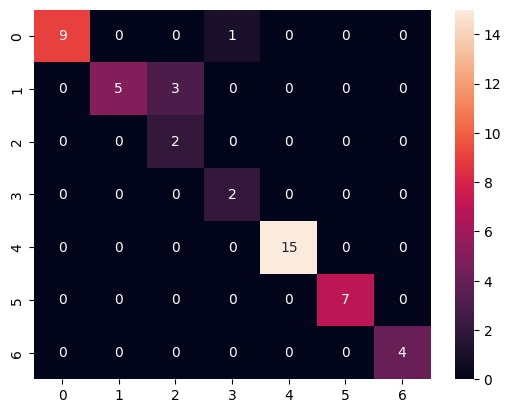

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

#### Chạy KFold

In [ ]:
fish_dataset = pd.read_csv("data/Fish.csv")
fish_dataset.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [ ]:
# Thực hiện các bướ chuẩn bị dữ liệu như thực hiện với phương pháp chia Random Split dữ liệu
X = fish_dataset.drop(["Species", "Width", "Length2", "Weight"], axis=1).to_numpy()
y = encoding_label(fish_dataset, classes).to_numpy()

kf.get_n_splits(X)
# Do k = 3 ta chia dữ liệu thành 3 phần trong đó 2 phần train và 1 test
# Trung bình kết quả 3 fold để được kết quả cuối cùng
for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    scaler = StandardScaler()
    transform = scaler.fit(X_train)
    X_train = transform.transform(X_train)
    X_test = transform.transform(X_test)

    freq_list = calculate_freq(y_train, classes)
    freq_list = 1/(freq_list + 0.00001)

    y_train = convert_to_one_hot(y_train, len(classes))
    X_train = reshape_data(X_train)

    w, b= train_ANN(X_train, y_train)
    test1 = reshape_data(X_test)
    y_pred = test(test1, w, b)
    print("Fold " + str(idx))
    print(classification_report(y_test, y_pred))

Epoch 1: loss = 12.428392, accuracy = 0.142855
Epoch 5001: loss = 0.317558, accuracy = 0.960990
Epoch 10001: loss = 0.038655, accuracy = 0.994166
Epoch 15001: loss = 0.015881, accuracy = 0.997485
Epoch 20001: loss = 0.009383, accuracy = 0.998506
Epoch 25001: loss = 0.006434, accuracy = 0.998968
Epoch 30001: loss = 0.004795, accuracy = 0.999227
Epoch 35001: loss = 0.003787, accuracy = 0.999389
(128, 53)
(7, 53)
(7, 53)
Fold 0
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.55      0.86      0.67         7
           2       0.00      0.00      0.00         2
           3       0.60      1.00      0.75         3
           4       0.92      0.58      0.71        19
           5       1.00      0.67      0.80         6
           6       0.31      1.00      0.47         4

    accuracy                           0.68        53
   macro avg       0.62      0.68      0.60        53
weighted avg       0.80      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5001: loss = 1.567050, accuracy = 0.892041
Epoch 10001: loss = 0.146478, accuracy = 0.976802
Epoch 15001: loss = 0.036872, accuracy = 0.993517
Epoch 20001: loss = 0.019873, accuracy = 0.996432
Epoch 25001: loss = 0.013053, accuracy = 0.997610
Epoch 30001: loss = 0.009597, accuracy = 0.998231
Epoch 35001: loss = 0.007525, accuracy = 0.998605
(128, 53)
(7, 53)
(7, 53)
Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.71      0.83      0.77         6
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         4
           4       0.95      0.95      0.95        19
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5

    accuracy                           0.92        53
   macro avg       0.78      0.83      0.80        53
weighted avg       0.90      0.92      0.91        53

Epoch 1: loss = 12.53

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5001: loss = 0.436465, accuracy = 0.934381
Epoch 10001: loss = 0.040994, accuracy = 0.992540
Epoch 15001: loss = 0.016640, accuracy = 0.996923
Epoch 20001: loss = 0.009640, accuracy = 0.998207
Epoch 25001: loss = 0.006532, accuracy = 0.998782
Epoch 30001: loss = 0.004828, accuracy = 0.999098
Epoch 35001: loss = 0.003789, accuracy = 0.999292
(128, 53)
(7, 53)
(7, 53)
Fold 2
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.43      0.60         7
           2       0.29      1.00      0.44         2
           3       1.00      0.25      0.40         4
           4       1.00      0.94      0.97        18
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         5

    accuracy                           0.85        53
   macro avg       0.87      0.80      0.76        53
weighted avg       0.93      0.85      0.85        53

